In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [4]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

# Load data

In [5]:
df_master = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')
df_master.drop(columns=['accn', 'name'], inplace=True)

df_plot = df_master.copy()
df_plot = np.log10(df_plot)
df_plot.replace(-1*np.inf, -10.0, inplace=True)

In [6]:
resin_names = {'cq':'Capto Q', 'xq':'Poros XQ', 'hq':'Poros 50 HQ'}
frac_names = {'a5':'A5', 'b12':'B12', 'd9':'D9', 'g12':'G12', 'eluate':'Adsorbate'}
percent_loading = {'a5':'5%', 'b12':'28%', 'd9':'53%', 'g12':'99%', 'eluate':'Adsorbate'}

new_names = []
for col in df_plot.columns:
    resin = col[:2]
    frac = col[3:]
    new_names.append(f'{resin_names[resin]} {percent_loading[frac]}')
    
df_plot.columns = new_names

In [7]:
df_ft = df_plot.copy()
df_ft.drop(columns=['Capto Q Adsorbate', 'Poros XQ Adsorbate', 'Poros 50 HQ Adsorbate'], inplace=True)
df_ft = df_ft[df_ft.sum(axis=1) > -10.0*len(df_ft.columns)]

df_eluate = df_plot.copy()
df_eluate = df_eluate[['Capto Q Adsorbate', 'Poros XQ Adsorbate', 'Poros 50 HQ Adsorbate']]
df_eluate = df_eluate[df_eluate.sum(axis=1) > -10.0*len(df_eluate.columns)]

# All data - log scale with species-specific normalization

/home/chase/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


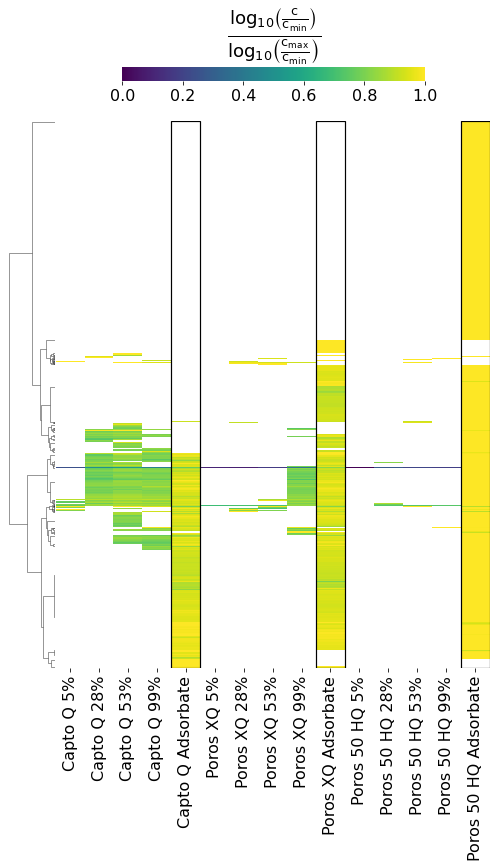

In [8]:
ax = sns.clustermap(df_plot, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(7, 10), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, mask=df_plot==-10.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'$\mathsf{\frac{log_{10}\left(\frac{c}{c_{min}}\right)}{log_{10}\left(\frac{c_{max}}{c_{min}}\right)}}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((4, 0), 1, len(df_plot), fill=False, edgecolor='black', lw=1.2))
r = heat.add_patch(Rectangle((9, 0), 1, len(df_plot), fill=False, edgecolor='black', lw=1.2))
r = heat.add_patch(Rectangle((14, 0), 1, len(df_plot), fill=False, edgecolor='black', lw=1.2))

# ax.savefig(f'./images/7b_swath_clustermap_all_log_color_scale.png', dpi=300, facecolor='white', transparent=False)

# FT

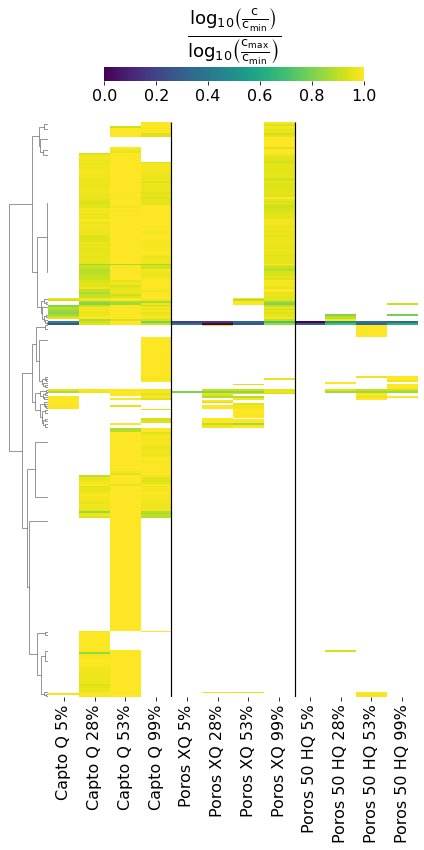

In [36]:
df = df_ft
ax = sns.clustermap(df, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(6, 10), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, mask=df==-10.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'$\mathsf{\frac{log_{10}\left(\frac{c}{c_{min}}\right)}{log_{10}\left(\frac{c_{max}}{c_{min}}\right)}}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((4, 0), 0, len(df), fill=False, edgecolor='black', lw=1.2))
r = heat.add_patch(Rectangle((8, 0), 0, len(df), fill=False, edgecolor='black', lw=1.2))

# ax.savefig(f'./images/7b_swath_clustermap_ft_log_color_scale.png', dpi=300, facecolor='white', transparent=False)

# Eluate

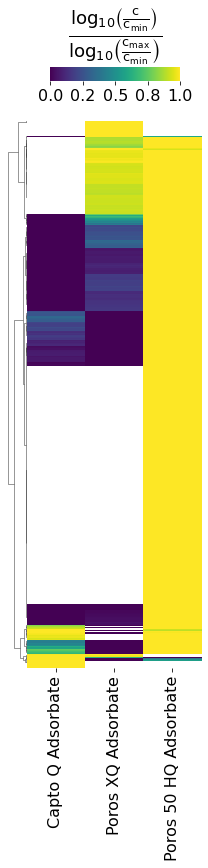

In [37]:
df = df_eluate
ax = sns.clustermap(df, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(3, 10), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, mask=df==-10.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'$\mathsf{\frac{log_{10}\left(\frac{c}{c_{min}}\right)}{log_{10}\left(\frac{c_{max}}{c_{min}}\right)}}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

# ax.savefig(f'./images/7b_swath_clustermap_eluate_log_color_scale.png', dpi=300, facecolor='white', transparent=False)

# Without species-specific normalization

/home/chase/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


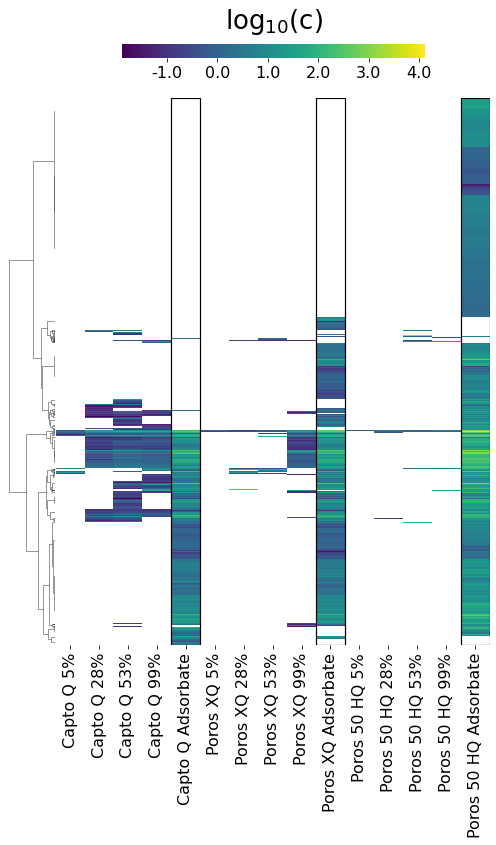

In [11]:
ax = sns.clustermap(df_plot, method='ward', dendrogram_ratio=(0.1, 0.05), figsize=(7, 10), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, mask=df_plot==-10.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'$\mathsf{log_{10}\left(c \right)}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((4, 0), 1, len(df_plot), fill=False, edgecolor='black', lw=1.2))
r = heat.add_patch(Rectangle((9, 0), 1, len(df_plot), fill=False, edgecolor='black', lw=1.2))
r = heat.add_patch(Rectangle((14, 0), 1, len(df_plot), fill=False, edgecolor='black', lw=1.2))

ax.savefig(f'./images/7b_swath_clustermap_all_log_color_scale_no_normalization.png', dpi=300, facecolor='white', transparent=False)

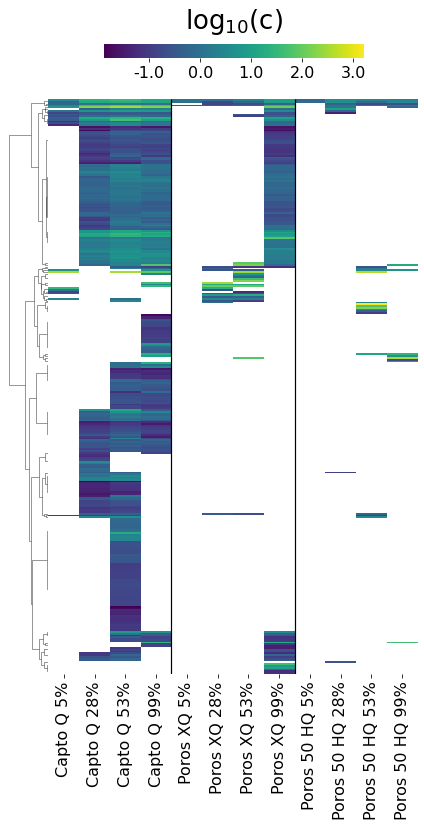

In [12]:
df = df_ft
ax = sns.clustermap(df, method='ward', dendrogram_ratio=(0.1, 0.05), figsize=(6, 10), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, mask=df==-10.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'$\mathsf{log_{10}\left(c \right)}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((4, 0), 0, len(df), fill=False, edgecolor='black', lw=1.2))
r = heat.add_patch(Rectangle((8, 0), 0, len(df), fill=False, edgecolor='black', lw=1.2))

ax.savefig(f'./images/7b_swath_clustermap_ft_log_color_scale_no_normalization.png', dpi=300, facecolor='white', transparent=False)

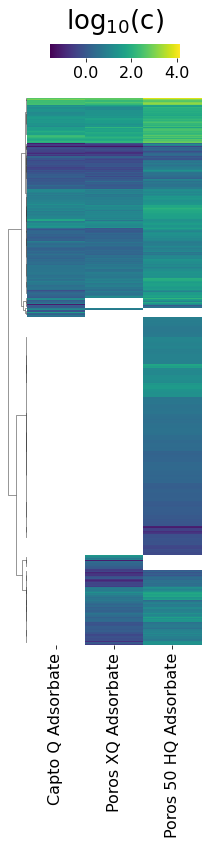

In [13]:
df = df_eluate
ax = sns.clustermap(df, method='ward', dendrogram_ratio=(0.1, 0.05), figsize=(3, 10), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, mask=df==-10.0, cmap='viridis')

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'$\mathsf{log_{10}\left(c \right)}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

ax.savefig(f'./images/7b_swath_clustermap_eluate_log_color_scale_no_normalization.png', dpi=300, facecolor='white', transparent=False)